## Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

**Objective**: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

**Dataset**: This lab utilizes the [Amazon UK product dataset](https://www.kaggle.com/datasets/asaniczka/uk-optimal-product-price-prediction/)
which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.

---


### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*


2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

---

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

In [58]:
from scipy.stats import chi2_contingency
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [21]:
df = df[df["price"] <= 200] # As I did on the previous lab, I will delete everything that is over 200 on price so plots are easier to read.
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [22]:
crosstab = pd.crosstab(df["category"], df["isBestSeller"])

crosstab["proportion"] = crosstab[True] / (crosstab[True] + crosstab[False])

sorted_crosstab = crosstab.sort_values(by="proportion", ascending=False)

print(sorted_crosstab)
# The most chances to become a best seller are for grocery, smart home security and health. Even though, the chances are so low (less than 6% become best sellers)


isBestSeller                                       False  True  proportion
category                                                                  
Smart Home Security & Lighting                        94     6    0.060000
Grocery                                             9005   555    0.058054
Health & Personal Care                              9012   552    0.057716
Wind Instruments                                     129     7    0.051471
Mobile Phone Accessories                             245    11    0.042969
Professional Medical Supplies                        165     7    0.040698
Billiard, Snooker & Pool                             194     8    0.039604
Material Handling Products                           100     4    0.038462
Home Brewing & Wine Making                           179     7    0.037634
Power & Hand Tools                                  8295   305    0.035465
Pet Supplies                                        9148   285    0.030213
Mirrors                  

In [13]:
chi2, p, dof, ex = chi2_contingency(crosstab)

# Compute Cramér's V
n = crosstab.sum().sum()
phi2 = chi2 / n
r, k = crosstab.shape
cramers_v = np.sqrt(phi2 / min(k-1, r-1))

print(f"Chi-square test statistic: {chi2}")
print(f"p-value: {p}")
print(f"Cramér's V: {cramers_v}")
# The strength of this association is weak, indicating that while certain product categories might have a 
# higher prevalence of best-sellers, the relationship is not strong.

Chi-square test statistic: 33817.01625630459
p-value: 0.0
Cramér's V: 0.08669547376451801


In [15]:
best_sellers_count = crosstab[True]

# Display the results
print(best_sellers_count)

category
3D Printers                         0
3D Printing & Scanning              2
Abrasive & Finishing Products       5
Action Cameras                      0
Adapters                            3
                                 ... 
Wind Instruments                    7
Window Treatments                   5
Women                             213
Women's Sports & Outdoor Shoes     20
eBook Readers & Accessories         0
Name: True, Length: 296, dtype: int64


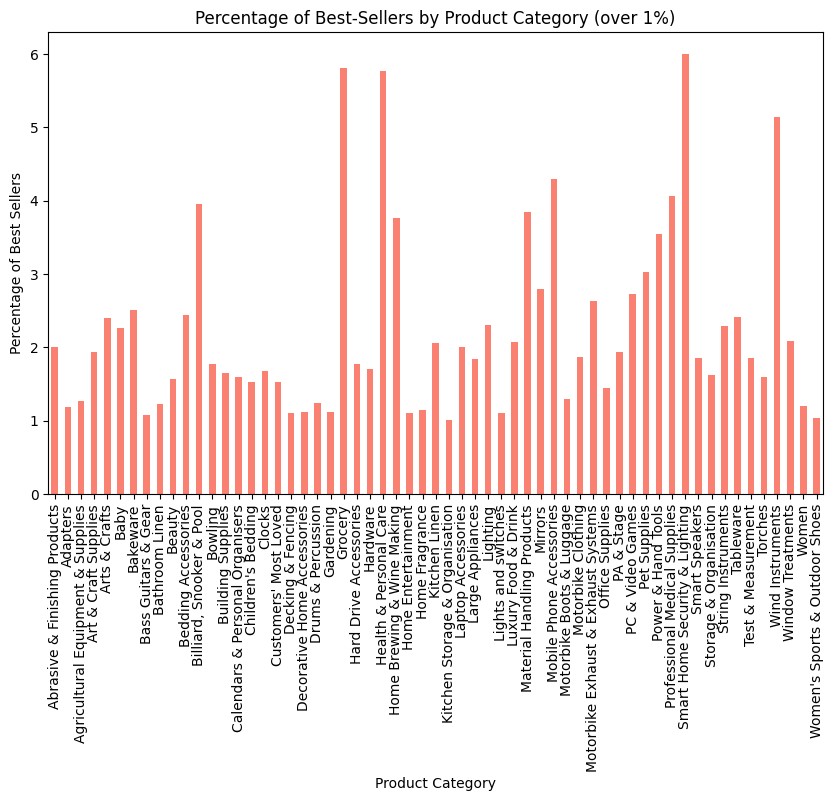

In [38]:
crosstab_percentage = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

# Filter categories with non-zero best-seller percentage
filtered_crosstab_percentage = crosstab_percentage[crosstab_percentage[True] > 1]

# Extract only the best-seller percentages
best_seller_percentages = filtered_crosstab_percentage[True]

# Plot the bar chart for the percentage of best sellers
plt.figure(figsize=(10, 6))
best_seller_percentages.plot(kind='bar', color='salmon')
plt.title("Percentage of Best-Sellers by Product Category (over 1%)")
plt.xlabel("Product Category")
plt.ylabel("Percentage of Best Sellers")
plt.show()
# As there were loads of categories with at least some best sellers, the plot was actually useles (could not read anything) so i
# filtered it for the ones that had at least 1% of best sellers. 
# The plot shows us now the percentage of best sellers per category when best sellers > 1%

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

---

In [40]:
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_df = df[(df["price"] >= lower_bound) & (df["price"] <= upper_bound)]

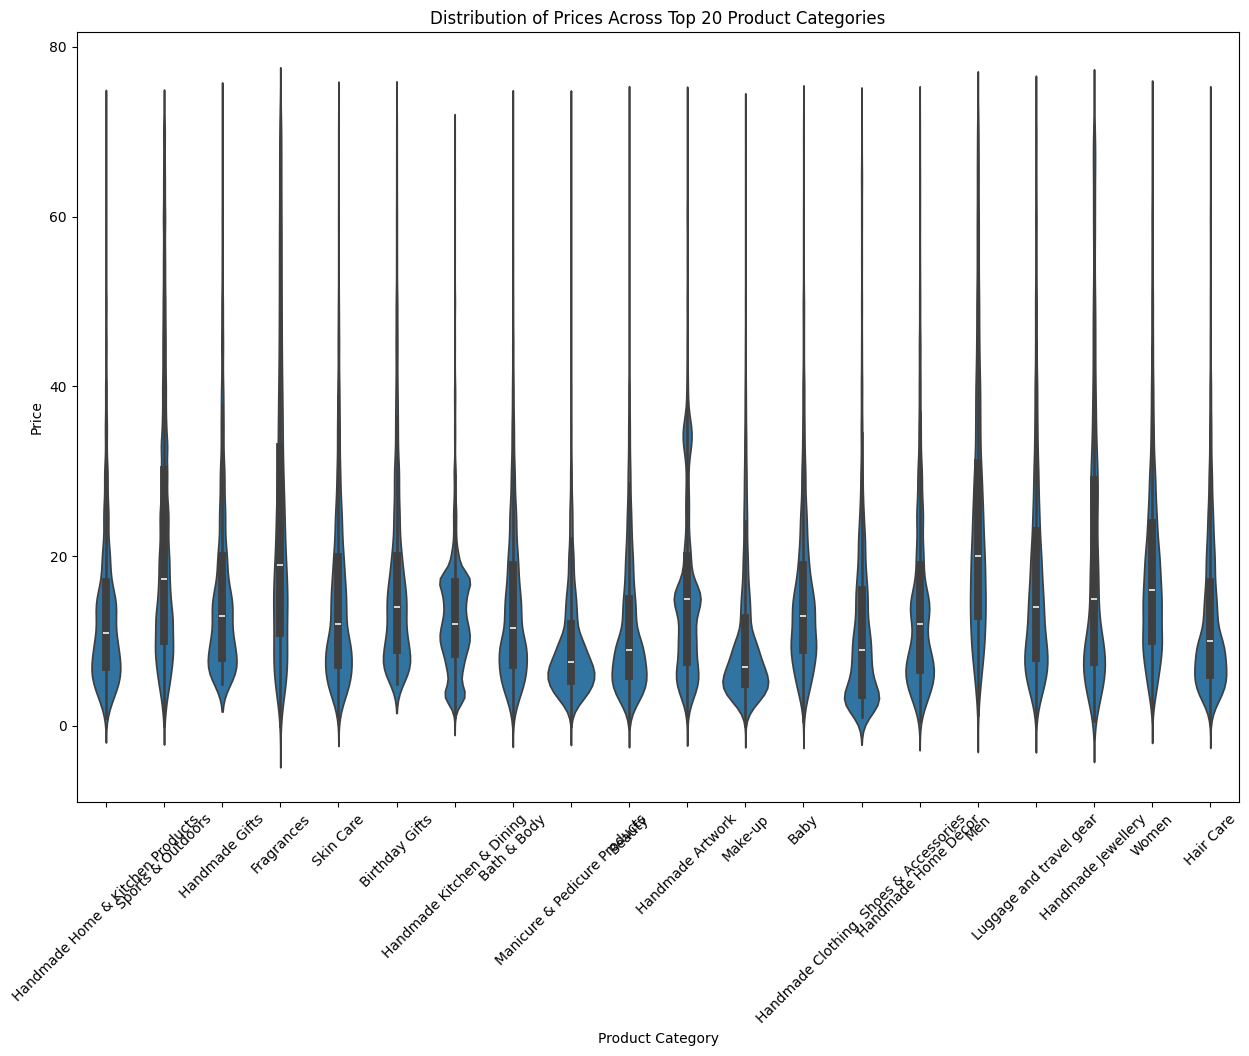

In [ ]:
top_20_categories = filtered_df['category'].value_counts().head(20).index

filtered_top_categories_df = filtered_df[filtered_df['category'].isin(top_20_categories)]

# Create the violin plot
plt.figure(figsize=(15, 10))
sns.violinplot(x='category', y='price', data=filtered_top_categories_df)
plt.title("Distribution of Prices Across Top 20 Product Categories")
plt.xlabel("Product Category")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()
# Between fragances and men are the ones with higher median price.


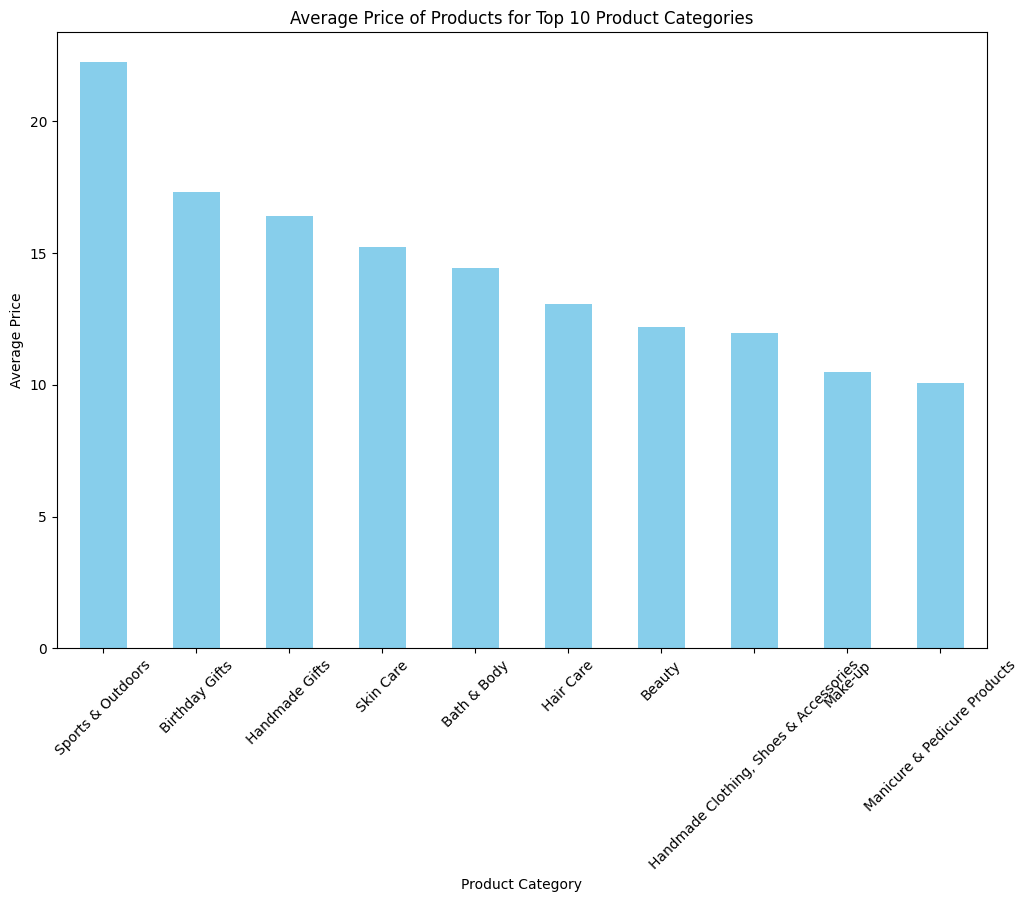

Average prices for each top category:
category
Bath & Body                               14.437519
Beauty                                    12.183243
Birthday Gifts                            17.321675
Hair Care                                 13.069570
Handmade Clothing, Shoes & Accessories    11.962179
Handmade Gifts                            16.414573
Make-up                                   10.496160
Manicure & Pedicure Products              10.070495
Skin Care                                 15.222881
Sports & Outdoors                         22.262379
Name: price, dtype: float64


In [45]:
top_10_categories = filtered_df['category'].value_counts().head(10).index

filtered_top_categories_df = filtered_df[filtered_df['category'].isin(top_10_categories)]

avg_price_per_category = filtered_top_categories_df.groupby('category')['price'].mean()

plt.figure(figsize=(12, 8))
avg_price_per_category.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Average Price of Products for Top 10 Product Categories")
plt.xlabel("Product Category")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.show()

print("Average prices for each top category:")
print(avg_price_per_category)


In [46]:
# Curious to see that the average prices are different form global to top 10 products. Bath n body tops the first one but it is
# the 5th condsidering top 10 prods.

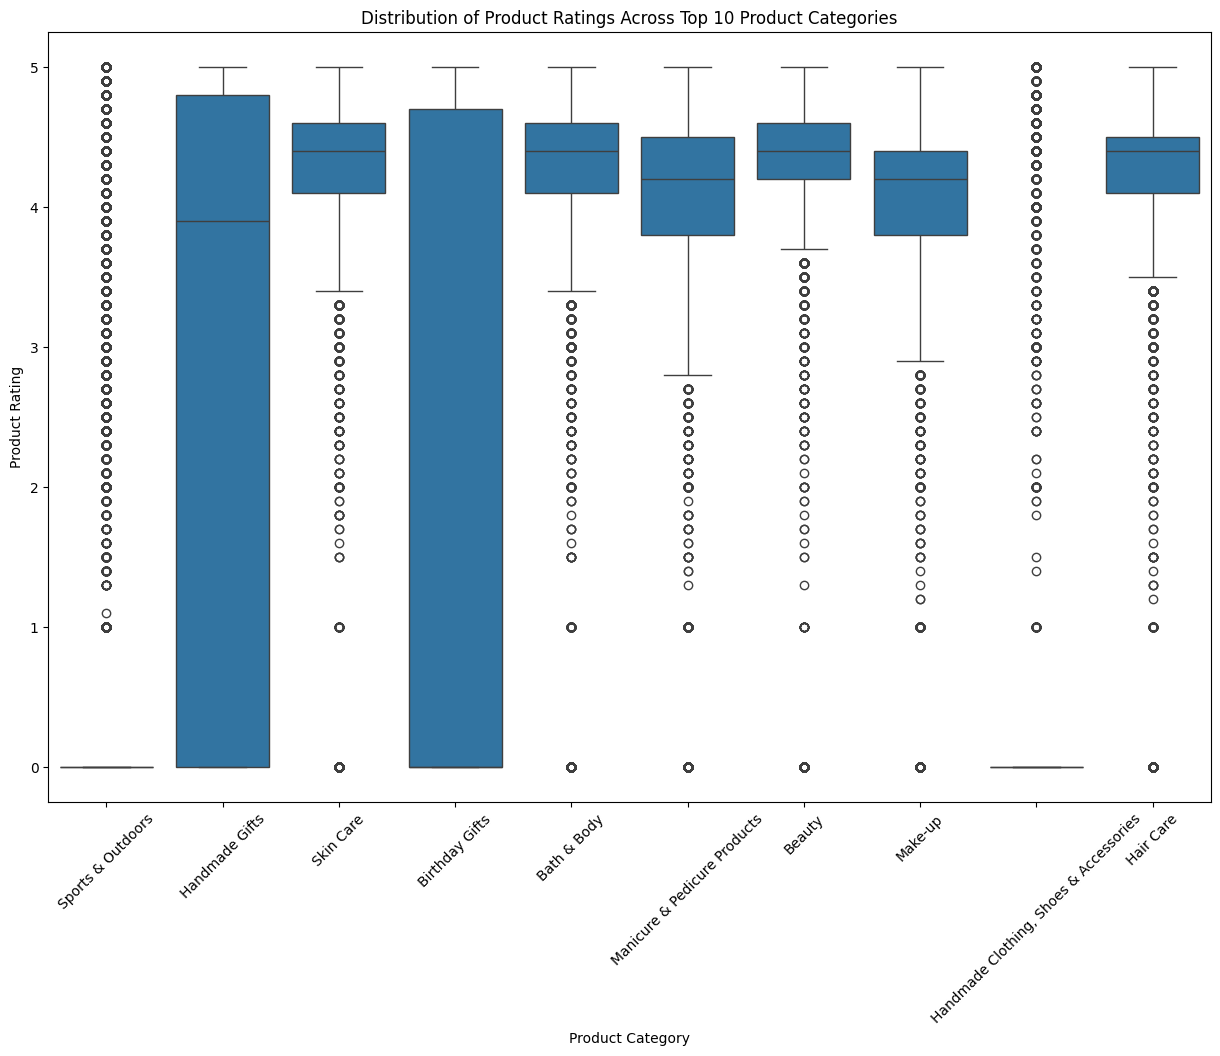

In [47]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='category', y='stars', data=filtered_top_categories_df)
plt.title("Distribution of Product Ratings Across Top 10 Product Categories")
plt.xlabel("Product Category")
plt.ylabel("Product Rating")
plt.xticks(rotation=45)
plt.show()


In [49]:
# The fact that for example sports and handmade clothing are with a box plot as a line might be because the most grades are "o"
# this could mean that because most of em are 0, the other are considered outliers.
# Beauty or haircase seems to have the besst median value from top 10

In [48]:
median_ratings_per_category = df.groupby('category')['stars'].median()

highest_median_rating_category = median_ratings_per_category.idxmax()
highest_median_rating = median_ratings_per_category.max()

print(f"The product category with the highest median rating is '{highest_median_rating_category}' with a median rating of {highest_median_rating:.1f}.")


The product category with the highest median rating is 'Computer Memory' with a median rating of 4.7.



### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?
	
2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 

---

In [ ]:
correlation = df['price'].corr(df['stars'])
print(f"Correlation coefficient between price and stars: {correlation:.2f}")
# Correlation is almost 0, so really weak one.

Correlation coefficient between price and stars: -0.08


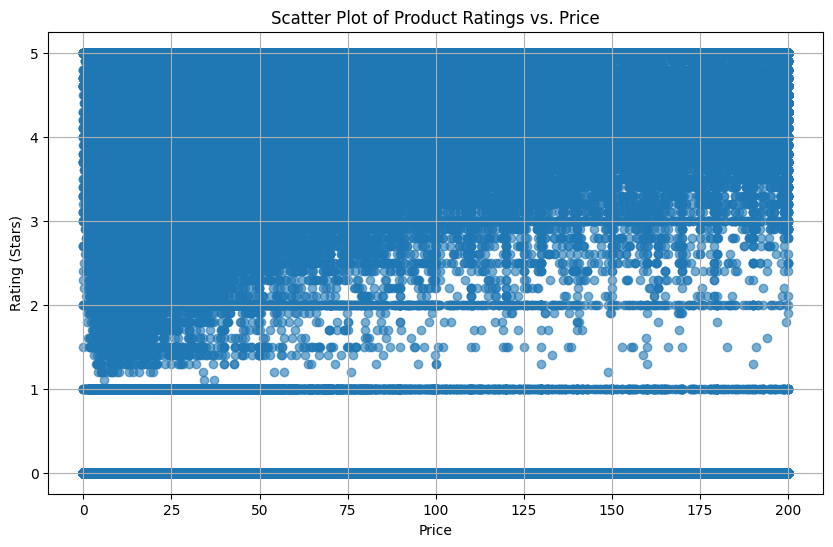

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['price'], df['stars'], alpha=0.6)
plt.title("Scatter Plot of Product Ratings vs. Price")
plt.xlabel("Price")
plt.ylabel("Rating (Stars)")
plt.grid(True)
plt.show()
# Looks like people are not able to give decimals in their ratings between 0 and 1

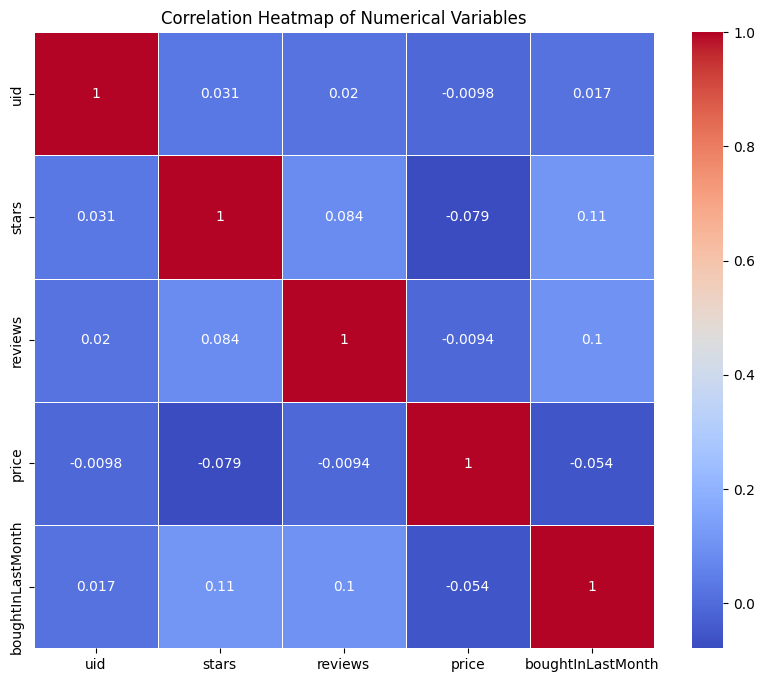

In [ ]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
corr_matrix = numerical_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Variables")
plt.show()
# Correlations are really weak. We cannot confirm that some of the variables depend on others.


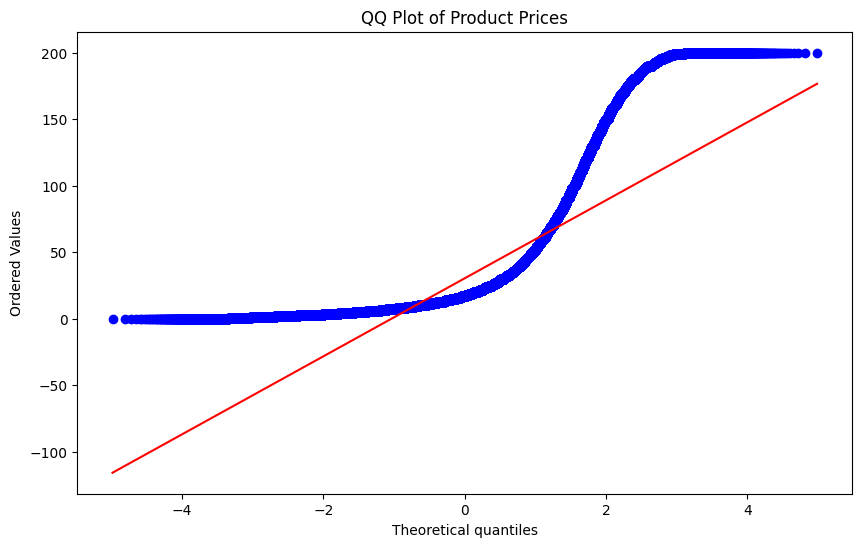

In [60]:
plt.figure(figsize=(10, 6))
stats.probplot(df['price'], dist="norm", plot=plt)
plt.title("QQ Plot of Product Prices")
plt.show()
